In [1]:
%matplotlib nbagg

# Variance of SAXS data

There has been a long discussion about the validity (or not) of pixel splitting regarding the propagation of errors.

## System under study

Let's do a numerical experiment, simulating the following experiment:

* Detector: 1024x1024 square pixels of 100µm each, assumed to be poissonian. 
* Geometry: The detector is placed at 1m from the sample, the beam center is in the corner of the detector
* Intensity: the maximum signal on the detector is 10 000 photons per pixel, each pixel having a minimum count of a hundreed.
* Wavelength: 1 Angstrom
* During the whole studdy, the solid-angle correction will be discarded, same for solid angle corrections.

Now we define some constants for the studdy:

In [2]:
pix = 100e-6
shape = (1024, 1024)
npt = 1000
nimg = 1000
wl = 1e-10
I0 = 1e4
Rg = 1.
kwarg = {"npt":npt, 
         "method": "nosplit_csr_ocl_gpu", 
         "correctSolidAngle":False, 
         "polarization_factor":None,
         "safe":False}

In [3]:
import numpy
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm
import pyFAI
print(pyFAI.version)
from pyFAI.detectors import Detector
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.gui import jupyter
detector = Detector(pix, pix)
detector.shape = detector.max_shape = shape
print(detector)

0.16.0-beta0
Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m


In [4]:
ai =AzimuthalIntegrator(dist=1, poni1=0., poni2=0., detector=detector, wavelength=wl)
print(ai)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 0.000000e+00, 0.000000e+00m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1000.000mm	Center: x=0.000, y=0.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


<IPython.core.display.Javascript object>


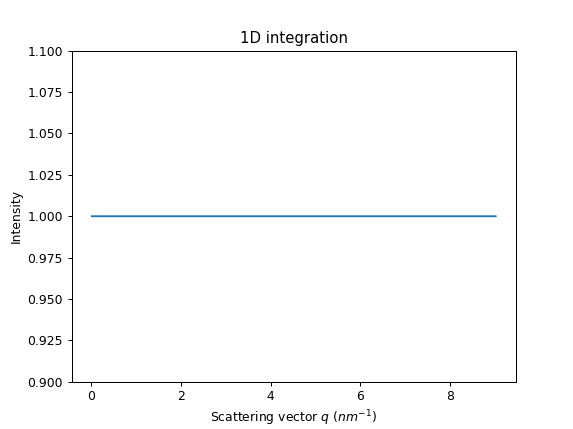

(0.9, 1.1)

In [5]:
res_flat = ai.integrate1d(numpy.ones(detector.shape), **kwarg)
crv = jupyter.plot1d(res_flat)
crv.axes.set_ylim(0.9,1.1)

<IPython.core.display.Javascript object>


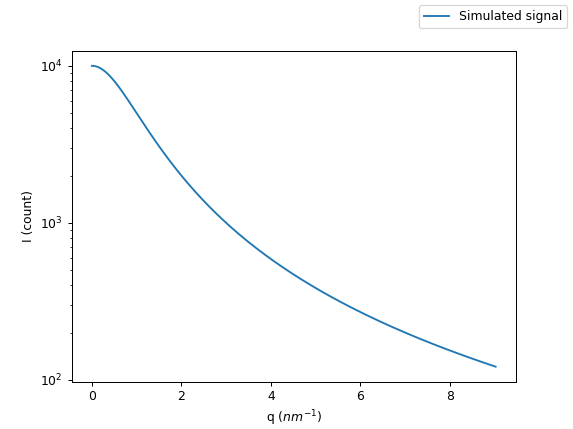

In [6]:
q = numpy.linspace(0, res_flat.radial.max(), npt)
# Simple decay in q**-2 to take into account the solid angle
I = I0/(1+q**2)
fig, ax = subplots()
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
fig.legend()

<IPython.core.display.Javascript object>


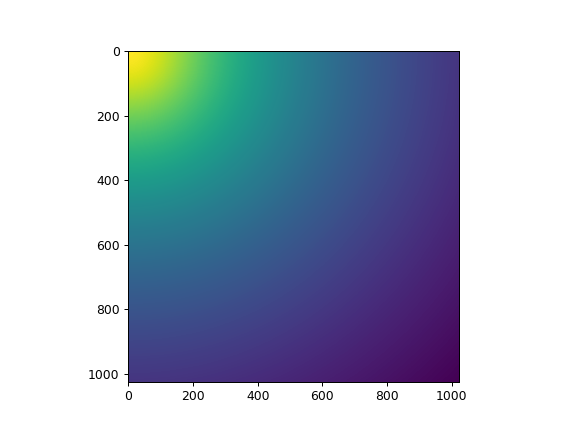

In [7]:
#Reconstruction of diffusion image:

img_theo = ai.calcfrom1d(q, I, dim1_unit="q_nm^-1", correctSolidAngle=False)
fig, ax = subplots()
ax.imshow(img_theo, norm=LogNorm())

In [8]:
%%time

# Now construct the large dataset from poissonian statistics
#this is slow and takes a lot of memory !
if "dataset" not in dir():
    dataset = numpy.random.poisson(img_theo, (nimg,)+img_theo.shape)
# else avoid wasting time
print(dataset.size/(1<<20), "MBytes", dataset.shape)

1000.0 MBytes (1000, 1024, 1024)
CPU times: user 1min 21s, sys: 1.44 s, total: 1min 23s
Wall time: 1min 23s


In [9]:
%%time
img_avg = dataset.mean(axis=0)
img_std = dataset.std(axis=0)
error = img_theo - img_avg
print("Error max:", abs(error.max()), "Error mean", abs(error.mean()))
print("Deviation on variance", abs(img_std**2-img_theo).max())


Error max: 11.388897908989748 Error mean 0.00016117392478402854
Deviation on variance 1534.8914985677166
CPU times: user 5.71 s, sys: 1.38 s, total: 7.09 s
Wall time: 7.11 s


<IPython.core.display.Javascript object>


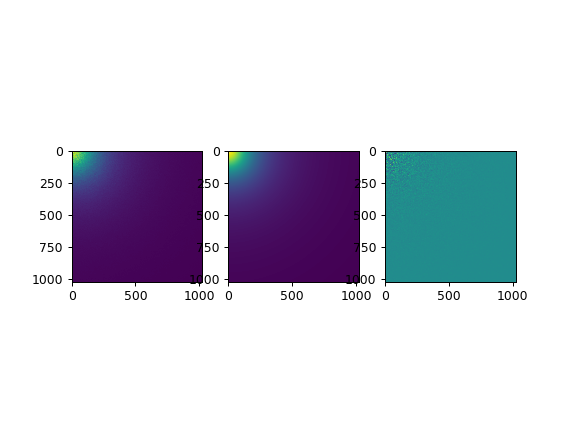

-0.7039750021661328

In [10]:
fig, ax = subplots(1,3)
ax[0].imshow(img_std**2)
ax[1].imshow(img_theo)
ax[2].imshow(img_std**2-img_theo)
(img_std**2-img_theo).mean()

In [11]:
def chi2_curves(res1, res2):
    """Calculate the Chi2 value for a pair of integrated data"""
    I = res1.intensity
    J = res2.intensity
    l = len(I)
    assert len(J) == l
    sigma_I = res1.sigma
    sigma_J = res2.sigma
    return ((I-J)**2/(sigma_I**2+sigma_J**2)).sum()/(l-1)


In [12]:
%%time
results = []
for i in range(nimg):
    data = dataset[i, :, :]
    results.append(ai.integrate1d(data, variance=data, **kwarg))
print(data.shape)

(1024, 1024)
CPU times: user 4.43 s, sys: 176 ms, total: 4.61 s
Wall time: 4.61 s


In [13]:
chi2_curves(results[0], results[1])

1.0681791410551176

In [14]:
c2 = []
for i in range(nimg):
    res1 = results[i]
    for j in range(i):
        c2.append(chi2_curves(res1, results[j]))
c2 = numpy.array(c2)

<IPython.core.display.Javascript object>


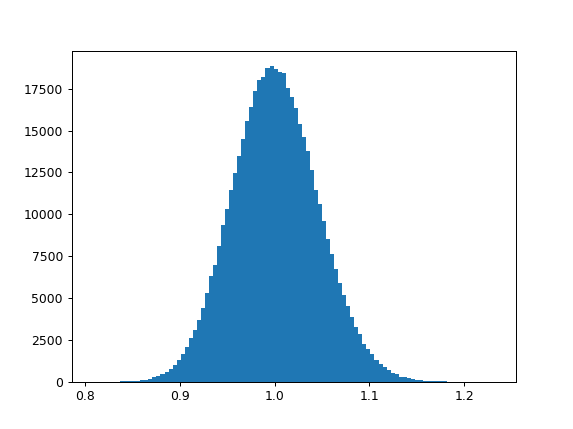

In [15]:
fig, ax = subplots()
h,b,_ = ax.hist(c2, 100)

<IPython.core.display.Javascript object>


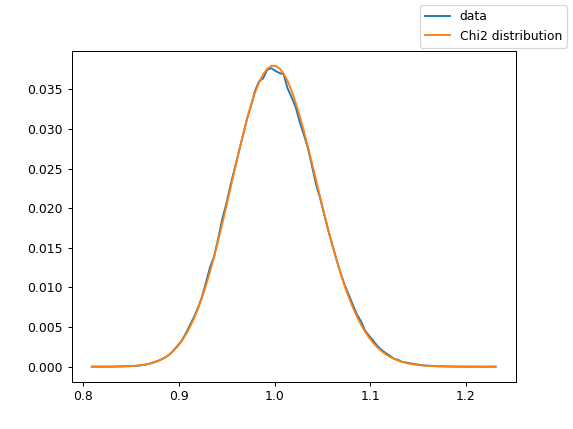

In [16]:
#Comparison between the obtained distribution and the a chi-squared continuous random variable.
from scipy.stats import chi2 as chi2_dist
x_data = 0.5*(b[1:] +b[:-1])
y_data = h/len(c2) # normalized
fig, ax = subplots()
ax.plot(x_data, y_data, label="data")
y_sim = chi2_dist.pdf(x_data*(nimg-1), nimg)
y_sim /= sum(y_sim) #normalized as well
ax.plot(x_data, y_sim, label="Chi2 distribution")
fig.legend()

In [17]:
low_lim, up_lim = chi2_dist.ppf([0.005, 0.995], nimg) / (nimg - 1)
print(low_lim, up_lim)
(c2<low_lim).sum(),(c2>up_lim).sum()

0.889452976157626 1.1200681344576493


(2462, 2764)

# And with solid angle correction ?

<IPython.core.display.Javascript object>


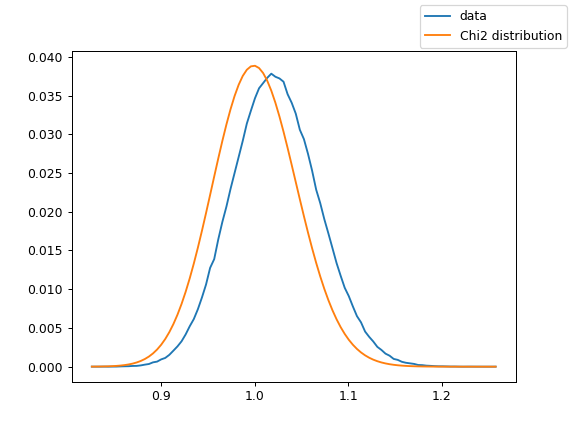

In [18]:
kwarg = {"npt":npt, 
         "method": "nosplit_csr_ocl_gpu", 
         "correctSolidAngle":True, 
         "polarization_factor":None,
         "safe":False}
ai.reset()
results = []
for i in range(nimg):
    data = dataset[i, :, :]
    results.append(ai.integrate1d(data, variance=data, **kwarg))
c2sa = []
for i in range(nimg):
    res1 = results[i]
    for j in range(i):
        c2sa.append(chi2_curves(res1, results[j]))
c2sa = numpy.array(c2sa)
h,b = numpy.histogram(c2sa, 100)
x_data = 0.5*(b[1:] +b[:-1])
y_data = h/len(c2) # normalized
fig, ax = subplots()
ax.plot(x_data, y_data, label="data")
y_sim = chi2_dist.pdf(x_data*(nimg-1), nimg)
y_sim /= sum(y_sim) #normalized as well
ax.plot(x_data, y_sim, label="Chi2 distribution")
fig.legend()

# With next generation azimuthal integrator ...

This does not yet exist in pyFAI but is on the roadmap since begining 2017 ... 
https://github.com/silx-kit/pyFAI/issues/520



In [19]:
from pyFAI.containers import Integrate1dResult
def integrate1d_ng(ai, data, variance, **kwargs):
    """Demonstrator for the new azimuthal integrator taking care of the normalization, 
    here implemented only on the solid-angle correction"""
    
    kwargs["correctSolidAngle"]=False
    
    sa = ai.solidAngleArray(ai.detector.shape)
    denom = ai.integrate1d(sa, **kwargs)
    signal = ai.integrate1d(data, **kwargs)
    sigma2 = ai.integrate1d(variance, **kwargs)
    result = Integrate1dResult(denom.radial, 
                               signal.sum/denom.sum, 
                               numpy.sqrt(sigma2.sum)/denom.sum)
    result._set_method_called("integrate1d_ng")
    result._set_compute_engine(kwargs.get("method", "unknown"))
    result._set_unit(signal.unit)
    result._set_sum(signal.sum)
    result._set_count(signal.count)
    return result
    
    
    

<IPython.core.display.Javascript object>


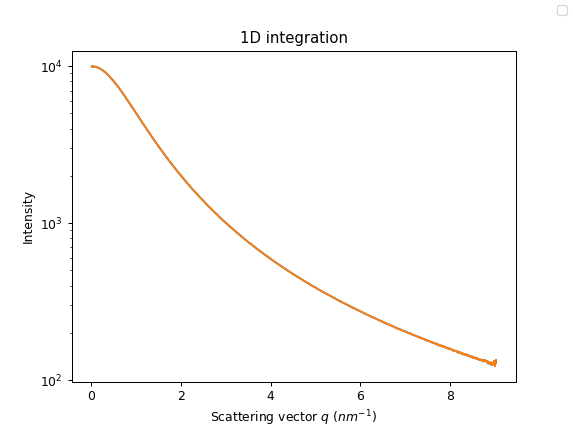

In [20]:
ai.reset()
fig, ax = subplots()
res_ng = integrate1d_ng(ai, data, variance=data, **kwarg)
jupyter.plot1d(res_ng, ax=ax)
ax.set_yscale("log")
jupyter.plot1d(ai.integrate1d(data, variance=data, **kwarg), ax=ax)
fig.legend()



<IPython.core.display.Javascript object>


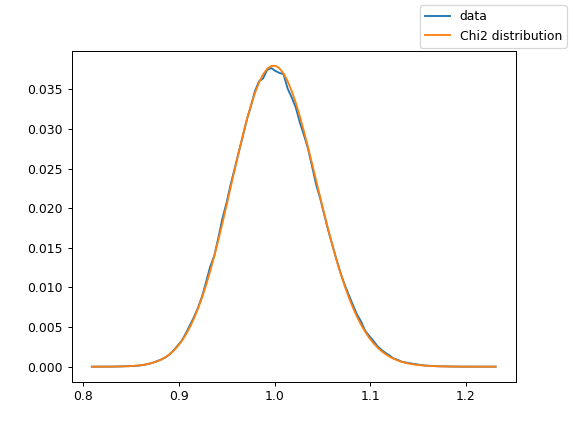

In [21]:
ai.reset()
results = []
for i in range(nimg):
    data = dataset[i, :, :]
    results.append(integrate1d_ng(ai, data, variance=data, **kwarg))
c2sa = []
for i in range(nimg):
    res1 = results[i]
    for j in range(i):
        c2sa.append(chi2_curves(res1, results[j]))
c2sa = numpy.array(c2sa)
h,b = numpy.histogram(c2sa, 100)
x_data = 0.5*(b[1:] +b[:-1])
y_data = h/len(c2) # normalized
fig, ax = subplots()
ax.plot(x_data, y_data, label="data")
y_sim = chi2_dist.pdf(x_data*(nimg-1), nimg)
y_sim /= sum(y_sim) #normalized as well
ax.plot(x_data, y_sim, label="Chi2 distribution")
fig.legend()